# Анализ пользовательского поведения в мобильном приложении

# Описание проекта
Я работаю в стартапе, который занимается продажей продуктов питания. Мек необходимо провести анализ того, как пользователи нашего сервиса взаимодействуют с мобильным приложением. 

## Описание данных

Датасет `logs_exp.csv` хранит следующие данные:

- `EventName` — название события;
- `DeviceIDHash` — уникальный идентификатор пользователя;
- `EventTimestamp` — время события;
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Цели исследования:

1. Необходимо ответить на следующие вопросы:
    
    - Как пользователи доходят до этапа покупки?
    - Сколько пользователей доходят до этого этапа, а сколько прерывают взаимодейстие ранее?
    - На каких этапах это происходит?

2. Необходмо провести анализ результатов A/A/B-эксперимента:

Дизайнеры решили поменять шрифты во ввсем приложении, в то время как менеджеры пришли к выводу, что это может отпугнуть наших клиентов. Для решения ситуации было принято следующее - пользователей разбили на 3 группы - 2 контрольные со старыми шрифтами (А) и одну с новыми (В). Нам необходимо провести анализ и узнать, какой шрифт работает лучше.


### Изучить файл с данными

Для начала загрузим все необходимые библиотеки

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(rc={'figure.figsize':(12, 8)})

import scipy.stats as st

import datetime as dt

import math 

from plotly import graph_objects as go

import numpy as np

Обратимся к датасету

In [34]:
try:
    logs = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
except:
    logs = pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp.csv', sep='\t')
    
    
logs.info()
display(logs)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


Отметим, что в датасете отсутствуют пропуски, однако есть ошибка в стилистическом обозначении столбцов. Приступип к предобработке данных

### Подготовим датасет

In [35]:
logs.columns = ['event_name', 'user_id', 'timestamp', 'exp_id']
logs.head()

,event_name,user_id,timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [36]:
logs.duplicated().sum()

413

Мы исправили стилистику наименования столбцов приведя ее к "змейке". Проверим какой процент составляют дубли



In [37]:
result = logs.duplicated().sum() / len(logs) * 100
percentage = '{:.2f}%'.format(result)
print(percentage)

0.17%


Дубли составляют менее 1%, можно убрать их из базы. 

In [38]:
logs.drop_duplicates(inplace = True)
logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_name  243713 non-null  object
 1   user_id     243713 non-null  int64 
 2   timestamp   243713 non-null  int64 
 3   exp_id      243713 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 9.3+ MB


Проверим какое количество пользователей находится в каждой из контрольных групп (А/А/В)


In [39]:
print('Количество групп для эксперимента и событий в них:\n', logs['exp_id'].value_counts())
not_uniq_users = logs.groupby(['user_id']).agg({'exp_id' : 'nunique'}).reset_index()
print(f'Пользователей, попавших в обе группы: {not_uniq_users[not_uniq_users.exp_id != 1]["user_id"].count()}')

Количество групп для эксперимента и событий в них:
 248    85582
246    80181
247    77950
Name: exp_id, dtype: int64
Пользователей, попавших в обе группы: 0


Количество пользователей в группах отличаются, но не критично. При этом пользователей, которые находятся хотя бы в двух группах нет в базе данных.

Добавим столбцы с временем и датой.

In [40]:
logs['date_time'] = pd.to_datetime(logs['timestamp'], unit='s')
logs['date'] = logs['date_time']
logs['date'] = pd.to_datetime(logs['date'], format='%Y-%m-%d')

logs.info()
display(logs)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   timestamp   243713 non-null  int64         
 3   exp_id      243713 non-null  int64         
 4   date_time   243713 non-null  datetime64[ns]
 5   date        243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 13.0+ MB


,event_name,user_id,timestamp,exp_id,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25 11:48:42
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07 21:12:25
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07 21:13:59
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07 21:14:43
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07 21:14:58


### Изучим воронку продаж

**Сколько всего событий в логе?**

In [41]:
logs['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

**`MainScreenAppear`** - Появление главного экрана

**`OffersScreenAppear`** - Появление экрана с предложениями

**`CartScreenAppear`** - Появление экрана корзины

**`PaymentScreenSuccessful`** - Успешное завершение оплаты

**`Tutorial`** - Обучение/инструкция

Чаще всего встречается **`MainScreenAppear`**, реже всего **`Tutorial`**        

**Сколько всего пользователей в логе?**

In [42]:
print('Количество уникальных пользователей:', len(logs['user_id'].unique()))

Количество уникальных пользователей: 7551


Количество пользователей намного меньше чем строк в базе - один пользователь может совершать несколько действий

**Сколько в среднем событий приходится на пользователя?**

In [43]:
event_user = logs.groupby('user_id')['event_name'].count()
event_user.describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event_name, dtype: float64

Подтверждаем утверждение выше - в среднем пользователь совершает 32 операции. Уточним на графике распределение событий.

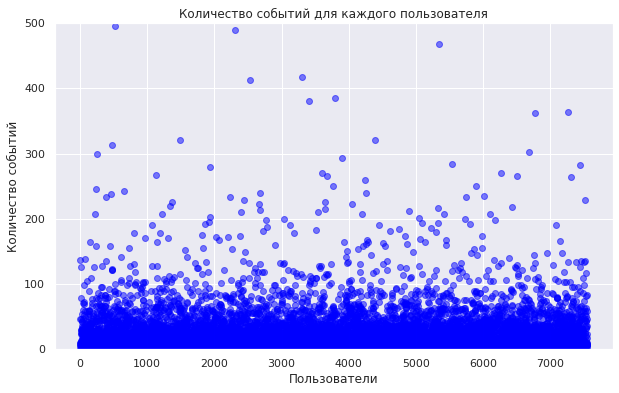

In [44]:
# Создание данных для графика
x = range(len(event_user))
y = event_user.values

# Построение графика
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue', alpha=0.5)

# Настройка осей и заголовка
plt.xlabel('Пользователи')
plt.ylabel('Количество событий')
plt.title('Количество событий для каждого пользователя')

# Установка предела для оси Y
plt.ylim(0, 500)

# Отображение графика
plt.show()

Как мы видим, действительно - большая часть пользователей совершает до 100 операций

**Данными за какой период мы располагаем? Найдем максимальную и минимальную дату**

In [45]:
print('Максимальная дата', logs['date'].max())
print('Минимальная дата', logs['date'].min())
print('Период исследуемых данных',logs['date_time'].max()-logs['date_time'].min())

Максимальная дата 2019-08-07 21:15:17
Минимальная дата 2019-07-25 04:43:36
Период исследуемых данных 13 days 16:31:41


Период в почти 2 недели считаю определенно достаточным для изучения в случае покупок продуктов питания, так как это постоянная потребность. Однако стоит обратить внимание влияют ли на данные исследования те пользователи, которые начали использовать продукт до анализа.

**Построим гистограмму по дате и времени**


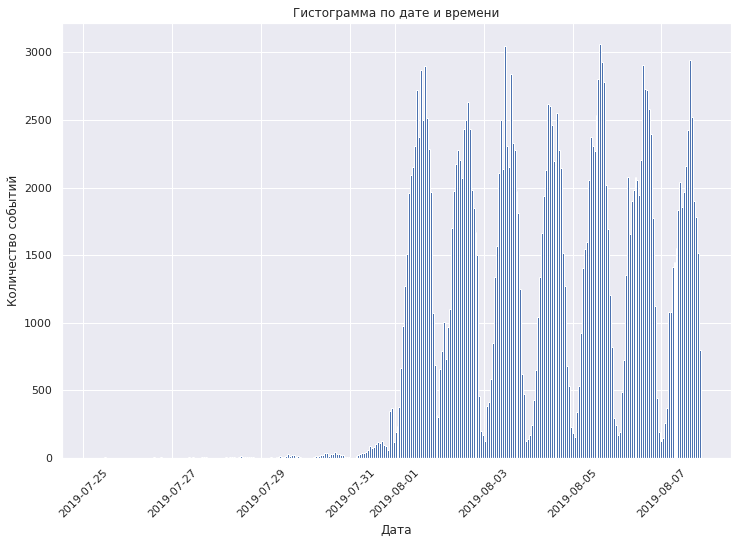

In [46]:
ax = logs['date_time'].hist(bins=312)
plt.title('Гистограмма по дате и времени')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.xticks(rotation=45)
plt.show()

Как мы видим из графика, полные данные мы имеем только с 1 августа, что означает о необходимости работы именно с этой группой пользователей - мы не сможем полностью проанализировать всю группу пользователей без искажения результата

In [47]:
limit_date = pd.to_datetime('2019-08-01', format = '%Y-%m-%d')
logs_full = logs[logs['date'] >= limit_date]

**Проверим как отразилапсь выборка на итоговых данных?**

In [48]:
print('Количество потерянных пользователей:',logs['user_id'].nunique()-logs_full['user_id'].nunique())
print('Процент потерь пользователей:', round(100-logs_full['user_id'].nunique()/logs['user_id'].nunique()*100, 2), '%')
print('Количество потерянных событий:', len(logs)-len(logs_full))
print('Процент потерь событий:', round(100-len(logs_full)/len(logs)*100, 2), '%')


Количество потерянных пользователей: 17
Процент потерь пользователей: 0.23 %
Количество потерянных событий: 2826
Процент потерь событий: 1.16 %


Процент потерянных пользователей и событий менее 2%, что считаю допустимым. Ранее мы посмотрели количество событий в группах, теперь подтвердим тоже самое в очищенных данных, добавив к этому количество пользователей.

In [49]:
print('Номера групп и события в них:\n', logs_full['exp_id'].value_counts())

print('Количество пользователей в группах:\n', logs_full.groupby('exp_id')['user_id'].nunique())

Номера групп и события в них:
 248    84563
246    79302
247    77022
Name: exp_id, dtype: int64
Количество пользователей в группах:
 exp_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64


Как мы видим, количество событий и пользователей в группах примерно равно, что подтверждает возможность работать с данными. 

**Промежуточный итог:**

Как мы видим, что у нас есть хорошо сформированные группы в период с 1 по 7 августа 2019 года. В датасете есть 5 событий, большая часть пользователей совершает до 100 событий


### Изучим воронку событий

Ранее мы изучили количество событий в датасете, обратимся к ним с группировкой по пользователям

In [50]:
event_users = logs_full.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).to_frame().reset_index()
event_users

,event_name,user_id
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


Распределение аналогично. Уточним общее количество пользователей а так же посмотрим в процентах, как много из них прошли тот или иной этап. 

In [51]:
total_users = logs_full['user_id'].nunique()
print('Общее количество уникальных пользователей, совершивших события:', total_users)

event_users['percent'] = (event_users['user_id'] / total_users).round(3) * 100 
event_users

Общее количество уникальных пользователей, совершивших события: 7534


,event_name,user_id,percent
0,MainScreenAppear,7419,98.5
1,OffersScreenAppear,4593,61.0
2,CartScreenAppear,3734,49.6
3,PaymentScreenSuccessful,3539,47.0
4,Tutorial,840,11.1


Доли пользователей распределились так: 98.5 % пользователей побывало на главном экране, 61% ознакомились с предложениями, 49.6 % добавили продукты в корзину, 47% дошли до этапа ввода банковских данных, но только 11.1% прошли обучение по работе с приложением.

**В каком порядке происходят события? Все ли они выстраиваются в последовательную цепочку?**

Как я считаю происходит следующие - пользователи попадают на главный экран. В случае, если это первый запуск сервиса, происходит предложение с прохождением обучения. Этот этап пропускает большинство пользователей - возможно не хотят тратить время на то, что им интуитивно понятно. Затем они переходят на этап выбора продуктов, после чего добавляют понравившиеся предложения в корзину, затем оплачивают заказ.


**По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки от числа пользователей на предыдущем.**

In [52]:
event_users.drop([4], axis=0, inplace=True)
event_users['next_step'] = 1
for i in range(1, 4):
    event_users.loc[i, 'next_step'] = event_users.loc[i, 'user_id'] / (event_users.loc[i-1, 'user_id'])
event_users['previous_user_id'] = event_users['user_id'].shift(1)
event_users

,event_name,user_id,percent,next_step,previous_user_id
0,MainScreenAppear,7419,98.5,1.000000,NaN
1,OffersScreenAppear,4593,61.0,0.619086,7419.0
2,CartScreenAppear,3734,49.6,0.812976,4593.0
3,PaymentScreenSuccessful,3539,47.0,0.947777,3734.0


Как мы видим наибольшая часть пользователей останавливается на этапе просмотра предложений и не переходит дальше. Построим график для наглядности

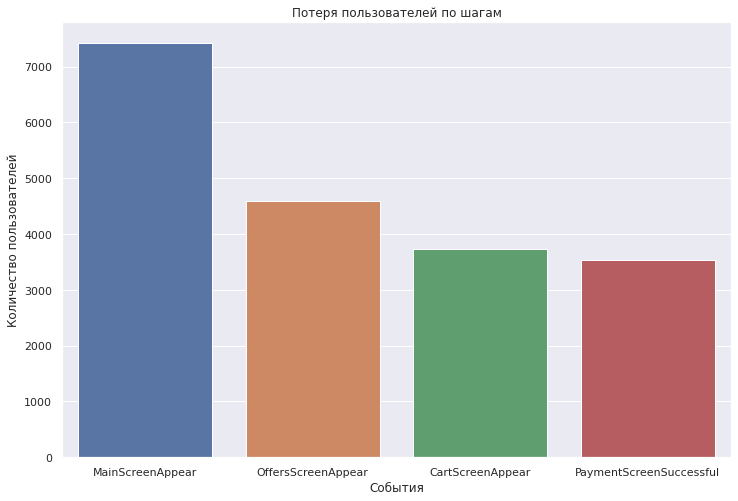

In [53]:
plt.figure()
sns.barplot(data=event_users.loc[0:4], x='event_name', y='user_id')
plt.title('Потеря пользователей по шагам')
plt.xlabel('События')
plt.ylabel('Количество пользователей')
plt.show()

Подтверждаю мысль - наибольшее количество пользователей "отваливается" на этапе просмотра предложений. Возможно это связано с тем, что они не нашли подходящих для себя выгодных предложений. 

**Какая доля пользователей доходит от первого события до оплаты?**

In [54]:
event_users 

fig = go.Figure()
fig = go.Figure(go.Funnel(
    y = event_users['event_name'],
    x = event_users['user_id'],
    textposition = "inside",
    textinfo = "value+percent initial",
    marker = {"color": "#1c1847"}))
fig.update_layout(title='Воронка событий по пользователям', title_x = 0.5)
fig.show()

Как видно из графика, только 48% всех пользователей проходят все этапы от главного экрана до ввода данных. Не стоит учитывать обучение, т.к. оно, скорее всего, опционально. 

**Промежуточный вывод**

Мы узнали количество событий и какие это события, увидели наиболее и наименее часто встречаемое событие, предположили то, в каком порядке пользователи взаимодействуют с платформой.

Можно сказать, что пользователи всегда сперва попадают на главный экран, из них лишь 48% доходят до этапа покупки, при этом только каждый десятый проходил обучение. Чаще всего клиенты уходят, не выбрав что-либо из предложений. 

### Изучим результаты эксперимента

Для начала вернемся к тем данным, которые мы выяснили ранее. 

In [55]:
logs_full.groupby('exp_id')['user_id'].nunique().to_frame()

,user_id
exp_id,
246,2484
247,2513
248,2537


In [56]:
group_246 = logs_full.query('exp_id == 246').groupby('exp_id')['user_id'].nunique().reset_index()
group_247 = logs_full.query('exp_id == 247').groupby('exp_id')['user_id'].nunique().reset_index()
ratio = 1 - group_246.iloc[0]['user_id'] / group_247.iloc[0]['user_id']
print('Разница между выборками 246 и 247 - {:.2%}'.format(ratio))

Разница между выборками 246 и 247 - 1.15%


In [57]:
all_groups = logs_full.pivot_table(
    index='exp_id', 
    columns='event_name', 
    values='user_id', 
    aggfunc='nunique')
all_groups = all_groups.reset_index()
all_groups

event_name,exp_id,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
0,246,1266,2450,1542,1200,278
1,247,1238,2476,1520,1158,283
2,248,1230,2493,1531,1181,279


Мы подтвердили количество пользователей в группах, а так же проверили, что разница в группах А и А незначительна.

Ранее мы мы выяснили, что самое популярное событие - появление главного экрана. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным. Проделаем то же самое для всех других событий. Можно ли сказать, что разбиение на группы работает корректно?

Сформулируем гипотезы:
*Н0* - доли уникальных посетителей, побывавших на этапе воронки, одинаковы.

*Н1* - между долями уникальных посетителей, побывавших на этапе воронки, есть значимая разница

Пороговое значение *alpha* примем за 5%.    
    
Создадим функцию для работы с группами. 

Для работы используем Z-критерий

*Z-критерий используется при проверке гипотез, чтобы оценить, является ли находка или ассоциация статистически значимыми или нет. В частности, он проверяет, совпадают ли два средних значения (нулевая гипотеза). Z-критерий может быть использован только в том случае, если известно стандартное отклонение генеральной совокупности и размер выборки составляет 30 точек данных или больше.*

In [58]:
def z_test(dataframe, num_group, alpha):
    #пользователи в каждой группе
    users = [dataframe.query('exp_id == @group')['user_id'].nunique() for group in num_group]
    #перебор экспериментальных групп по событиям и количество пользователей
    for event in dataframe.event_name.unique():
        events = [dataframe.query('exp_id == %d and event_name == "%s"' % (group, event))['user_id'].nunique() for group in num_group]
        
        p1 = events[0] / users[0] 
        p2 = events[1] / users[1] 
        
        p_combined = sum(events) / sum(users) 
        
        difference = p1 - p2 
        
        z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1 / users[0] + 1 / users[1]))
        
        distr = st.norm(0, 1) 
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        
        print('Событие:', event)
        print('p-значение: {p_value:}'.format(p_value=p_value))
        
        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы')
            
        print('****************************************')    

Проведем анализ между контрольными группами 246 и 247

Ввиду того, что одновременно будет проводиться 5 тестов, согласно поправке Бонферрони 
`alpha = 0.05/5 = 0.01`

In [63]:
z_test(logs_full, [246, 247], 0.01) 

Событие: Tutorial
p-значение: 0.9376996189257114
Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы
****************************************
Событие: MainScreenAppear
p-значение: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы
****************************************
Событие: OffersScreenAppear
p-значение: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы
****************************************
Событие: CartScreenAppear
p-значение: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы
****************************************
Событие: PaymentScreenSuccessful
p-значение: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы
****************************************


Уже статистически мы подтверждаем, что различий в группах А и А нет. Это необходимо для того, чтобы понять будет ли первая или вторая группа давать разные результаты при сравнении с группой В. Ввиду того, что мы увидели, что статистически значимых различий нет, мы без опасения можем приступать к дальнейшему анализу.

Вернемся к проверке идеи о изменения шрифта. 

Проверим различия между контрольной группой 246 и экспериментальной 248

In [64]:
z_test(logs_full, [246, 248], 0.01)

Событие: Tutorial
p-значение: 0.8264294010087645
Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы
****************************************
Событие: MainScreenAppear
p-значение: 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы
****************************************
Событие: OffersScreenAppear
p-значение: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы
****************************************
Событие: CartScreenAppear
p-значение: 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы
****************************************
Событие: PaymentScreenSuccessful
p-значение: 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы
****************************************


Теперь сравним между второй А группой и В.

In [65]:
z_test(logs_full, [247, 248], 0.01)

Событие: Tutorial
p-значение: 0.765323922474501
Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы
****************************************
Событие: MainScreenAppear
p-значение: 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы
****************************************
Событие: OffersScreenAppear
p-значение: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы
****************************************
Событие: CartScreenAppear
p-значение: 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы
****************************************
Событие: PaymentScreenSuccessful
p-значение: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы
****************************************


Статистических значимых различий между группами А и группой В не обнаружено.

Сравним результаты экспериментальной группы 248 с объединённой контрольной группой, добавим 247 в 246 группу

In [66]:
united = logs_full.copy()
united['exp_id'].replace({247: 246}, inplace=True)
z_test(united, [246, 248], 0.01)

Событие: Tutorial
p-значение: 0.764862472531507
Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы
****************************************
Событие: MainScreenAppear
p-значение: 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы
****************************************
Событие: OffersScreenAppear
p-значение: 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы
****************************************
Событие: CartScreenAppear
p-значение: 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы
****************************************
Событие: PaymentScreenSuccessful
p-значение: 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы
****************************************


Мы провели 20 проверок при значимости в 0.01. 

Даже в случае объединения обеих групп, мы видим, что различий по прохождению воронки уникальными пользователями при разных шрифтах отсутствует. Следовательно данное предложение можно считать неактуальным и использовать как старый шрифт, так и новый.

### Общий вывод:
1. Изучили полученные данные:

Мы провели предобработку данных, выявили количество пользователей, событий, провели фильтрацию по времени, отсеяв те данные, которые пришли в базу до 1 августа 2019 года.  

2. Получены данные по воронке событий

Всего у нас имеется пять типов событий в логах: MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful. Чаще всего из них встречается MainScreenAppear (появление главного экрана - 117328 раз), реже всего - Tutorial (обучение - 1005 раз);

Большая часть пользователей уходит на этапе выбора товара, те кто остались, в большинстве доходят до этапа совершения покупки. При этом по большей степени до финального этапа доходят менее 50% пользователей.

Позволю себе продублировать порядок этапов: Пользователи попадают на главный экран. В случае, если это первый запуск сервиса, происходит предложение с прохождением обучения. Этот этап пропускает большинство пользователей - возможно не хотят тратить время на то, что им интуитивно понятно. Затем они переходят на этап выбора продуктов, после чего добавляют понравившиеся предложения в корзину, затем оплачивают заказ. 

3. Были проведены А/А/В эксперименты

По их результату можно сказать, что изменение шрифтов никак не повлияло на итоговую конверсию.

Как аналитик, при постановке задачи о увеличении числа заказов, я бы предложил рассмотреть настройку контекстной рекламы - необходимо понять, что пользователь чаще всего покупает в магазине и на основании этого предлагать ему в первую очередь те продукты, которые для него наиболее важны. Как вариант, если пользователь часто не уходит дальше стартового экрана, но при этом проявляет интерес к приложению, стоит создавать для него "спец-предложения" на те товары, которые он просматривал ранее. Например, индивидуальная скидка для того. 
